In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np
from scipy import stats

# Set the Optuna logger to output only WARNING and higher levels
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

/Users/user/anaconda3/envs/GIGACOW/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/XGBMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-01-01,a624fb9a,SE-064c0cec-1189,3095,02 SLB,7.0,191.0,2022-1,30.77,0.000000,...,35.914865,0.856748,0.000000,0,0,0,0,-3.025000,28.012944,NaN
1,2022-01-02,a624fb9a,SE-064c0cec-1189,3096,02 SLB,7.0,192.0,2022-1,48.22,30.770000,...,35.799613,1.103224,0.243718,0,0,0,0,-0.279167,32.898193,NaN
2,2022-01-03,a624fb9a,SE-064c0cec-1189,3097,02 SLB,7.0,193.0,2022-1,30.53,39.495000,...,35.684360,1.023044,-0.083744,0,0,0,0,2.033333,36.760487,NaN
3,2022-01-04,a624fb9a,SE-064c0cec-1189,3098,02 SLB,7.0,194.0,2022-1,42.26,36.506667,...,35.569108,1.066796,0.040438,0,0,0,0,0.066667,31.939524,NaN
4,2022-01-05,a624fb9a,SE-064c0cec-1189,3099,02 SLB,7.0,195.0,2022-1,38.49,37.945000,...,35.453856,1.073339,0.003074,0,0,0,0,-3.700000,26.498206,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483097,2023-06-03,f454e660,SE-fcdf259d-0044-0,4150,41 Fjällko,10.0,347.0,2023-3,12.67,14.652000,...,13.608593,1.030966,-0.045706,0,1,0,0,12.666667,53.132530,NaN
483098,2023-06-04,f454e660,SE-fcdf259d-0044-0,4151,41 Fjällko,10.0,348.0,2023-3,22.31,14.030000,...,13.516773,1.108549,0.070579,0,1,0,0,13.079167,56.726870,NaN
483099,2023-06-05,f454e660,SE-fcdf259d-0044-0,4152,41 Fjällko,10.0,349.0,2023-3,12.84,14.984000,...,13.424952,1.109278,-0.006853,0,1,0,0,14.237500,58.482418,NaN
483100,2023-06-06,f454e660,SE-fcdf259d-0044-0,4153,41 Fjällko,10.0,350.0,2023-3,9.47,14.892000,...,13.333131,1.095617,-0.021300,0,1,0,0,15.345833,60.546358,NaN


## Farm a624fb9a

In [3]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change
def fit_xgboost_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(test_data[[feature]])
        mse = mean_squared_error(test_data['NormalizedDailyYield'], y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)
results_df

,SE_Number,MSE,Yield HeatStress,Reduction
0,SE-064c0cec-1189,0.005453,0.933644,0.066555
1,SE-30dc5787-1389,0.007856,0.930245,0.069954
2,SE-30dc5787-1396,0.007054,0.927040,0.073159
3,SE-a624fb9a-1162,0.005197,0.956807,0.043398
4,SE-a624fb9a-1193,0.110402,1.049457,-0.049233
...,...,...,...,...
119,SE-a624fb9a-1490,0.012592,0.958632,0.041574
120,SE-a624fb9a-1491,0.003214,0.972485,0.027723
121,SE-a624fb9a-1493,0.003894,0.776917,0.223249
122,SE-a624fb9a-1496,0.034713,0.956583,0.043622


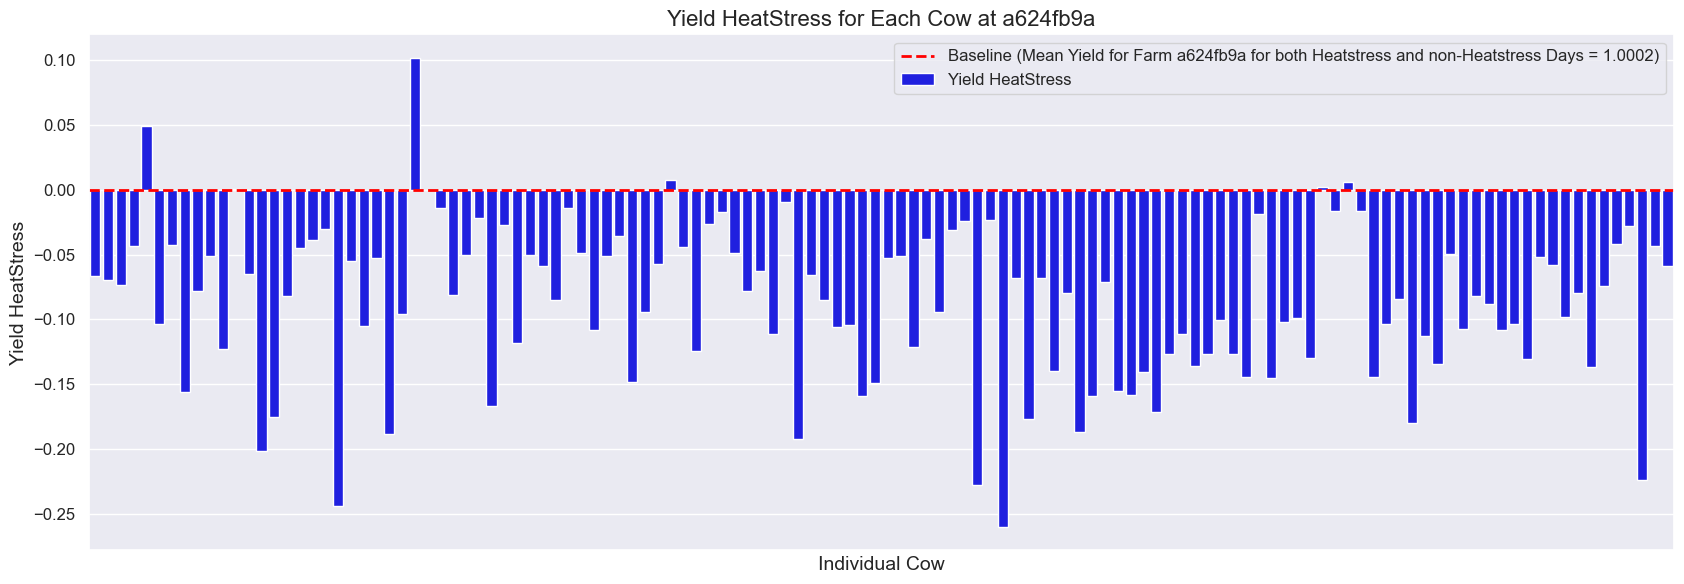

In [4]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

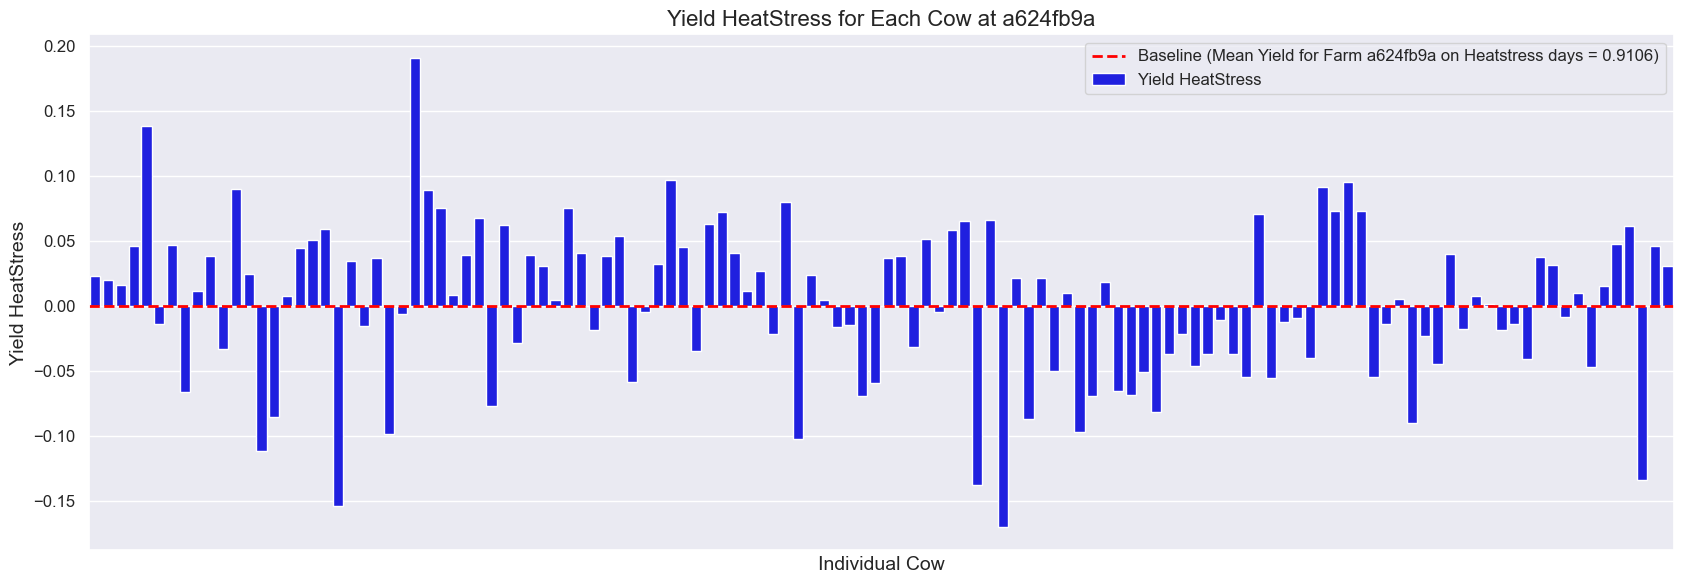

In [5]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm} on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## Farm 5c06d92d

In [6]:
# Filter data for a specific farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change
def fit_xgboost_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(test_data[[feature]])
        mse = mean_squared_error(test_data['NormalizedDailyYield'], y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)
results_df

,SE_Number,MSE,Yield HeatStress,Reduction
0,SE-5c06d92d-2000,0.000939,0.985977,0.013898
1,SE-5c06d92d-2016,0.017911,0.933714,0.066167
2,SE-5c06d92d-2055,0.011240,0.945370,0.054510
3,SE-5c06d92d-2058,0.008595,0.926385,0.073498
4,SE-5c06d92d-2211,0.004400,0.961574,0.038304
...,...,...,...,...
401,SE-5c06d92d-3462,0.000577,0.977586,0.022290
402,SE-5c06d92d-3463,0.009023,0.955531,0.044349
403,SE-5c06d92d-3465,0.006491,0.939820,0.060061
404,SE-5c06d92d-3467,0.003243,1.030007,-0.030137


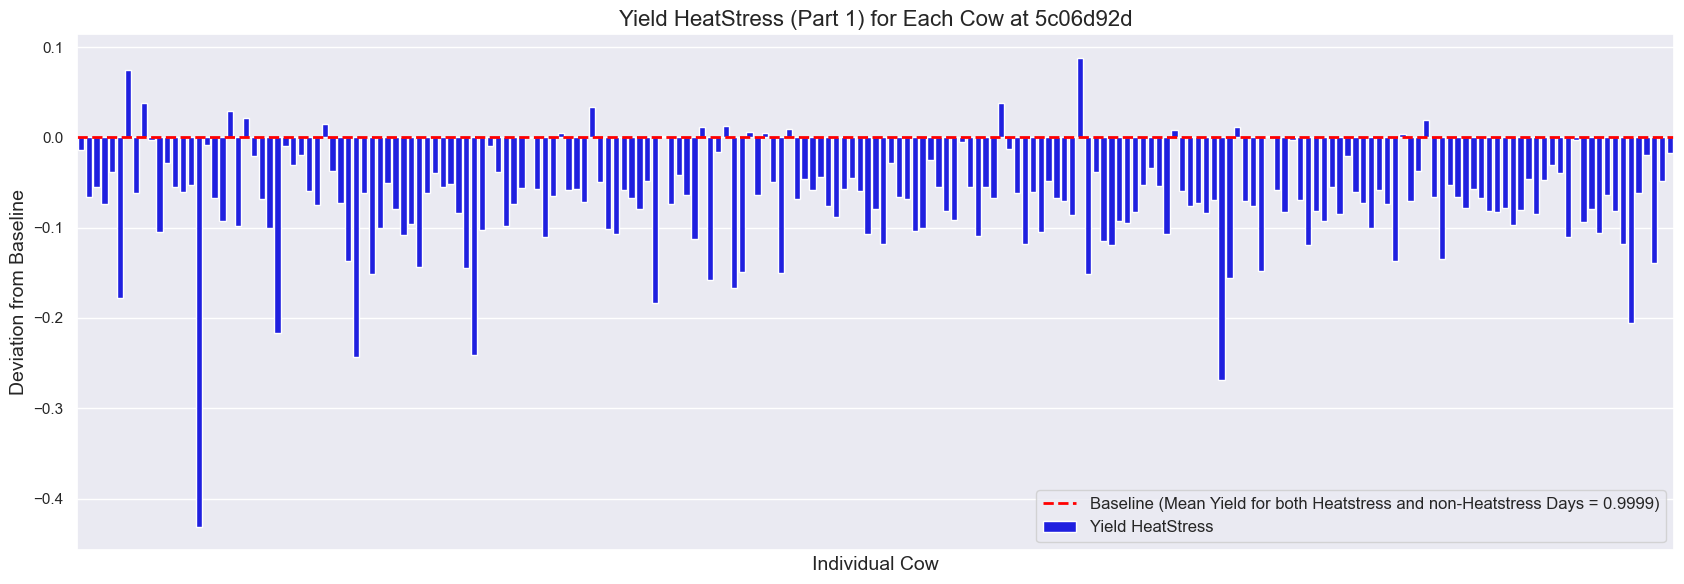

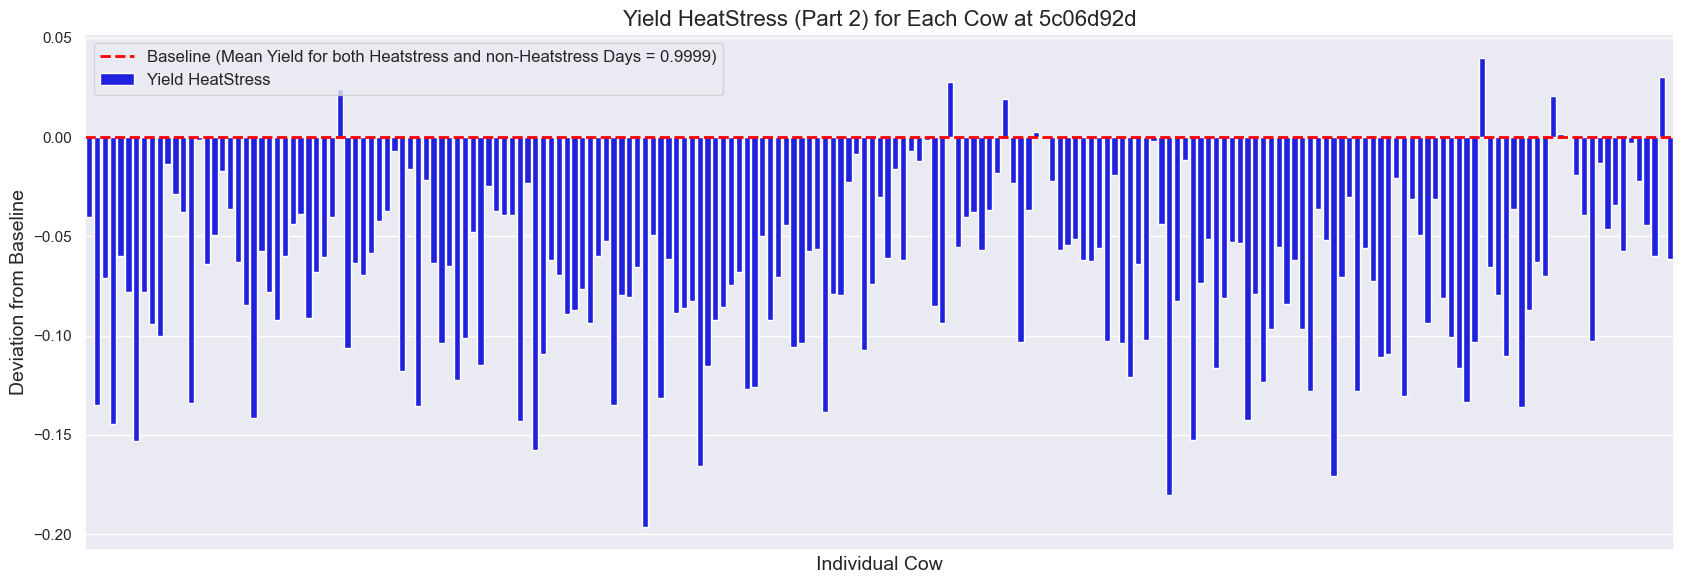

In [7]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

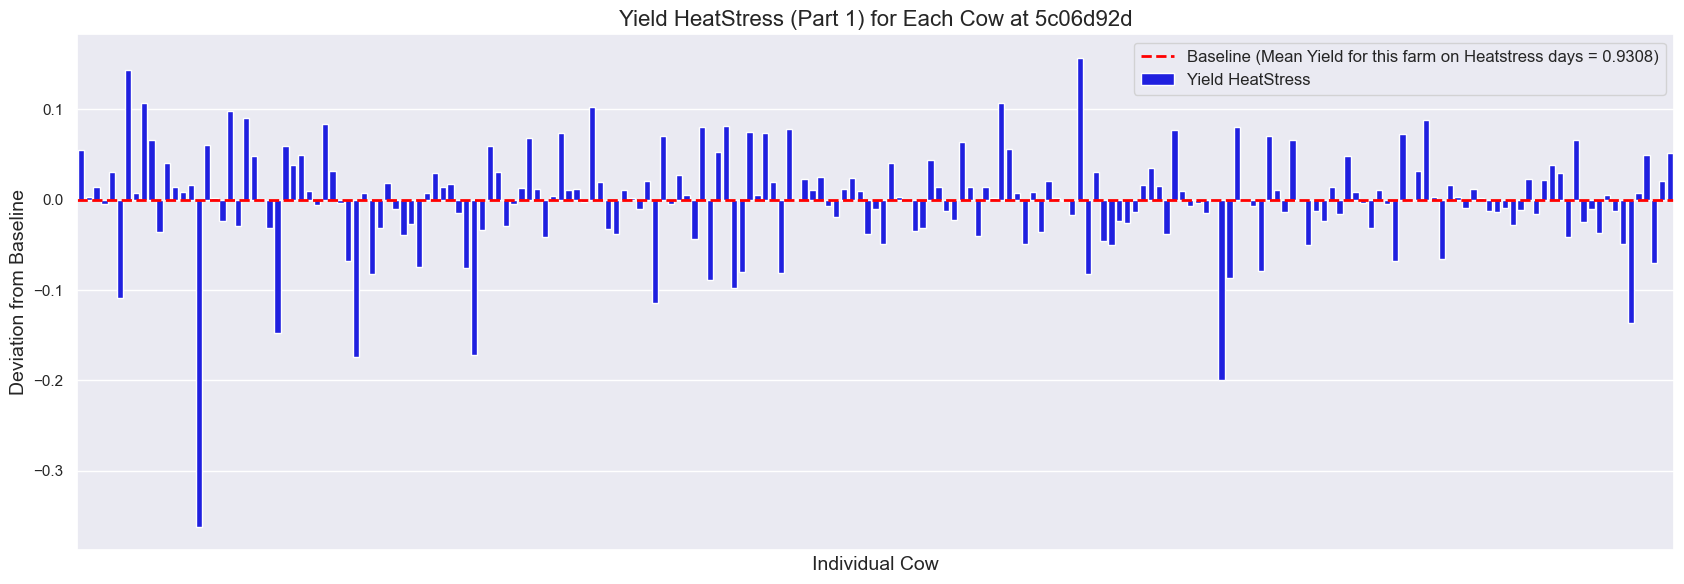

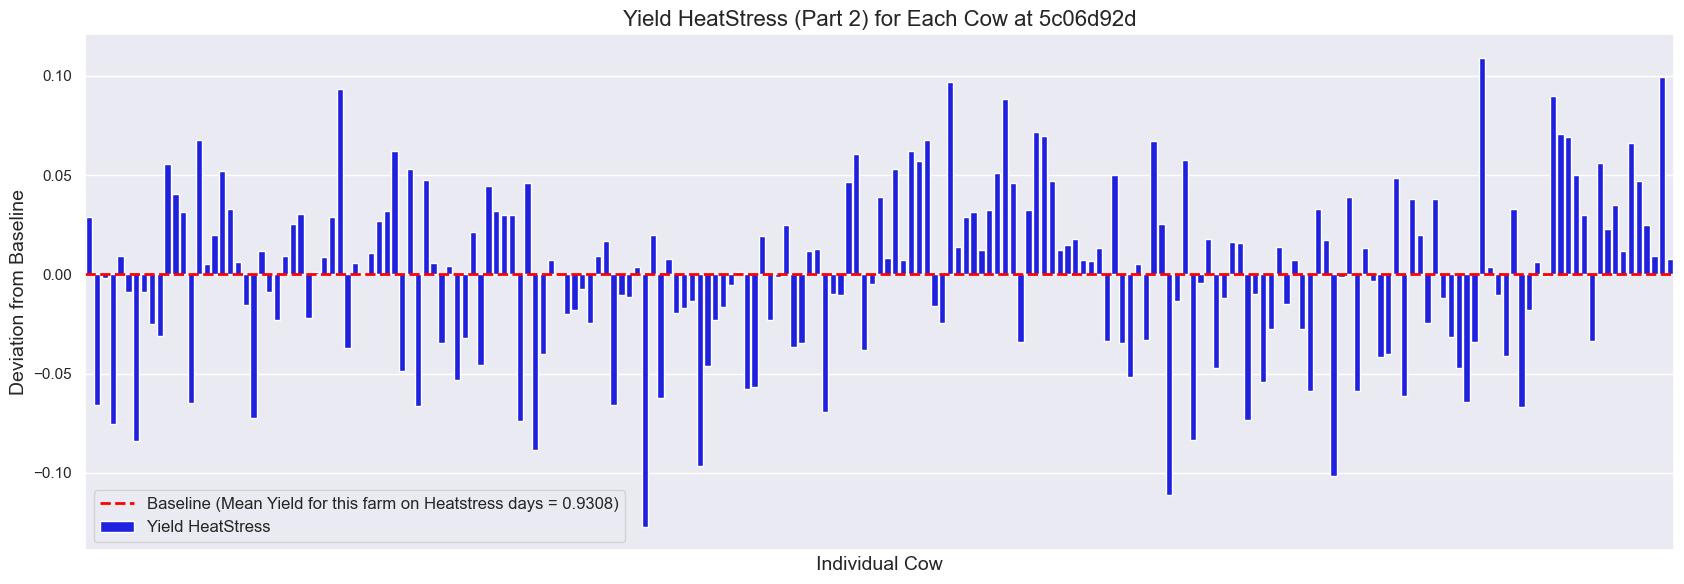

In [8]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Farm 752efd72

In [9]:
# Filter data for a specific farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change
def fit_xgboost_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(test_data[[feature]])
        mse = mean_squared_error(test_data['NormalizedDailyYield'], y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)
results_df

,SE_Number,MSE,Yield HeatStress,Reduction
0,SE-752efd72-0001,0.002793,0.892912,0.107145
1,SE-752efd72-0002,0.003828,1.085214,-0.085144
2,SE-752efd72-0008,0.007555,0.894402,0.105656
3,SE-752efd72-0010,0.013583,0.845786,0.154268
4,SE-752efd72-0011,0.014323,0.906889,0.093169
...,...,...,...,...
338,SE-752efd72-2793,0.000881,1.014186,-0.014121
339,SE-752efd72-2794,0.006657,0.911101,0.088958
340,SE-752efd72-2795,0.003975,1.017253,-0.017188
341,SE-752efd72-2796,0.005400,0.961865,0.038197


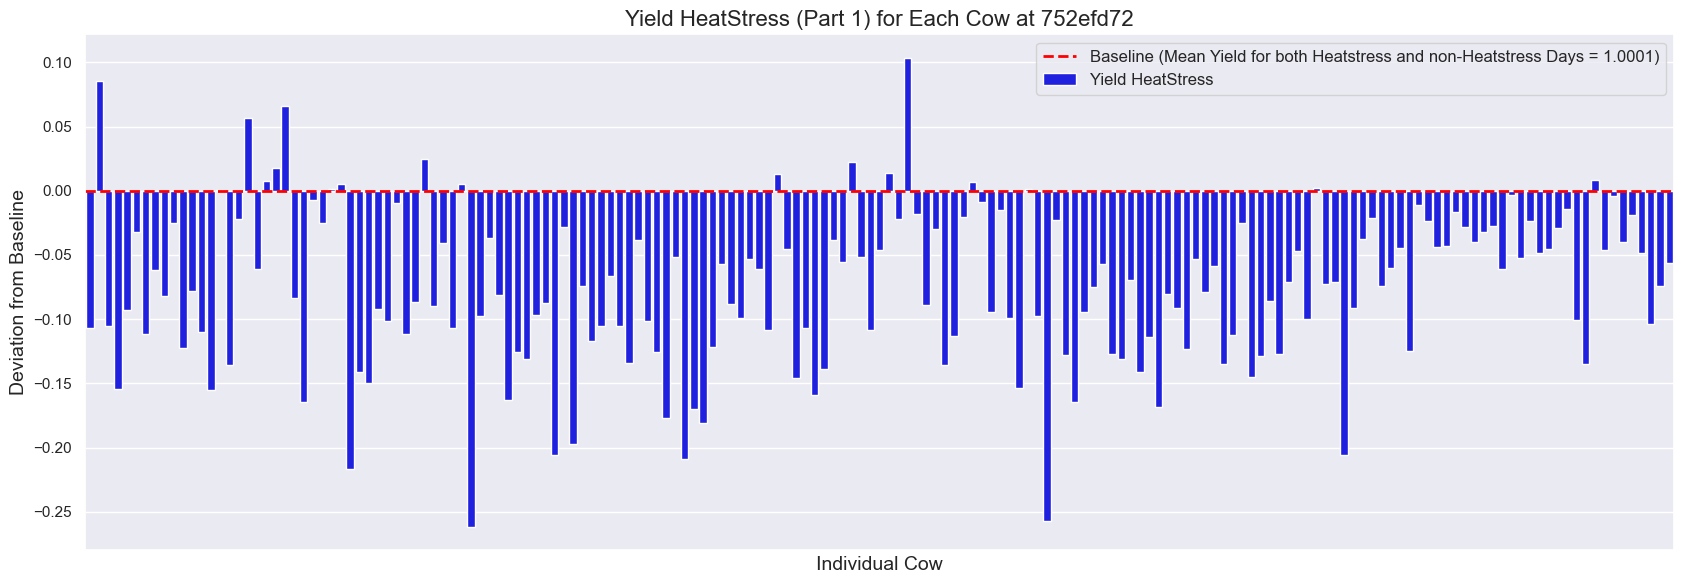

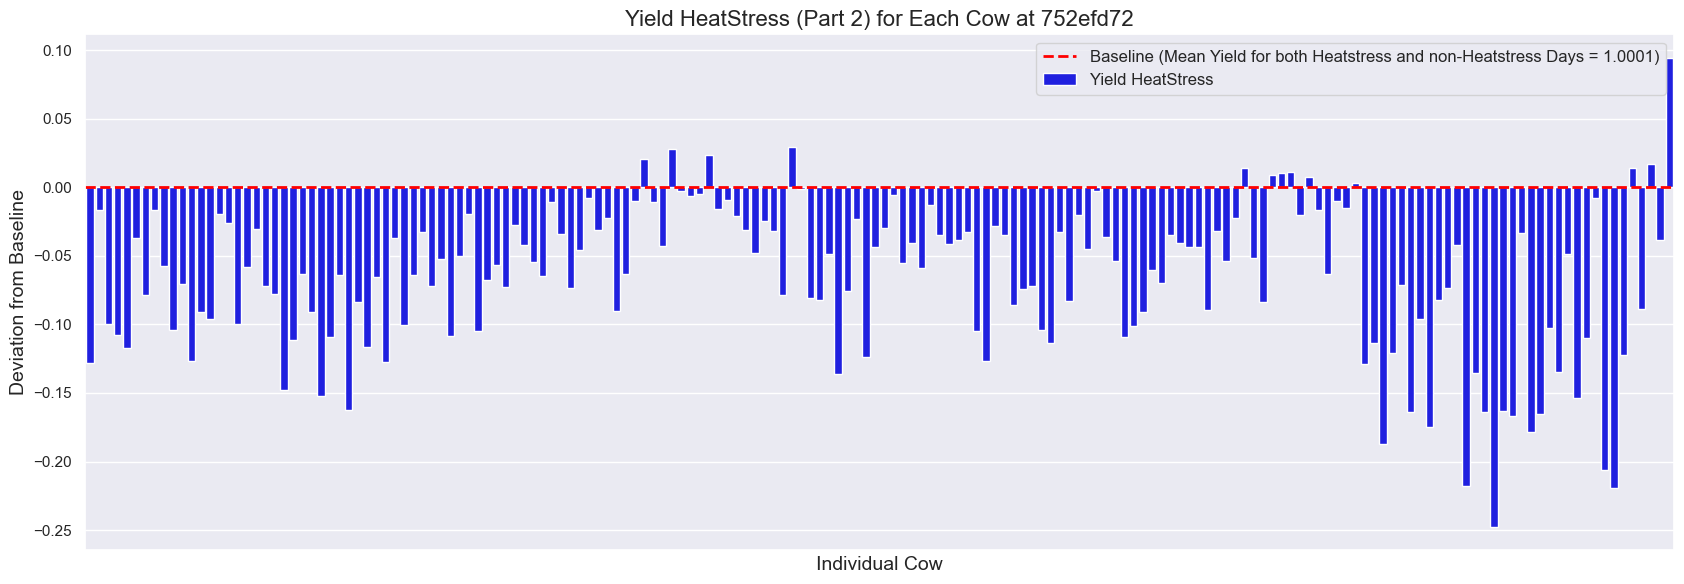

In [10]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

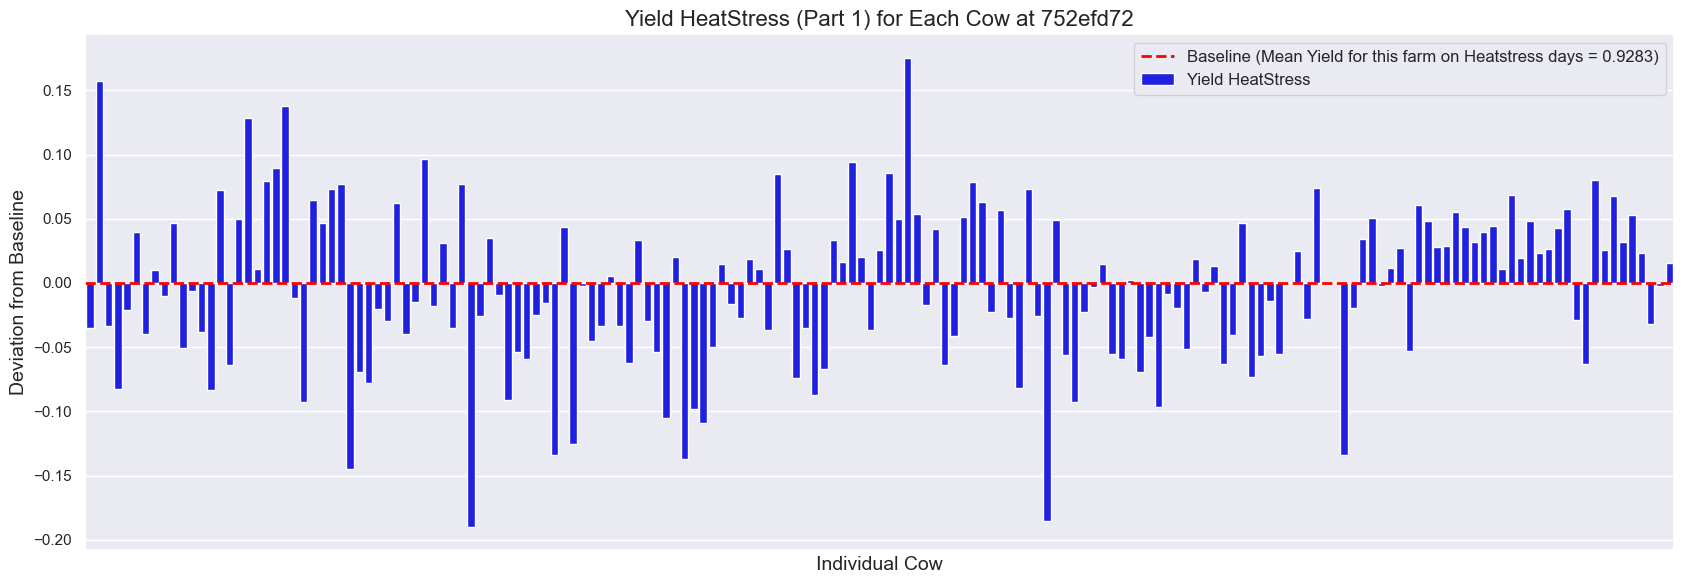

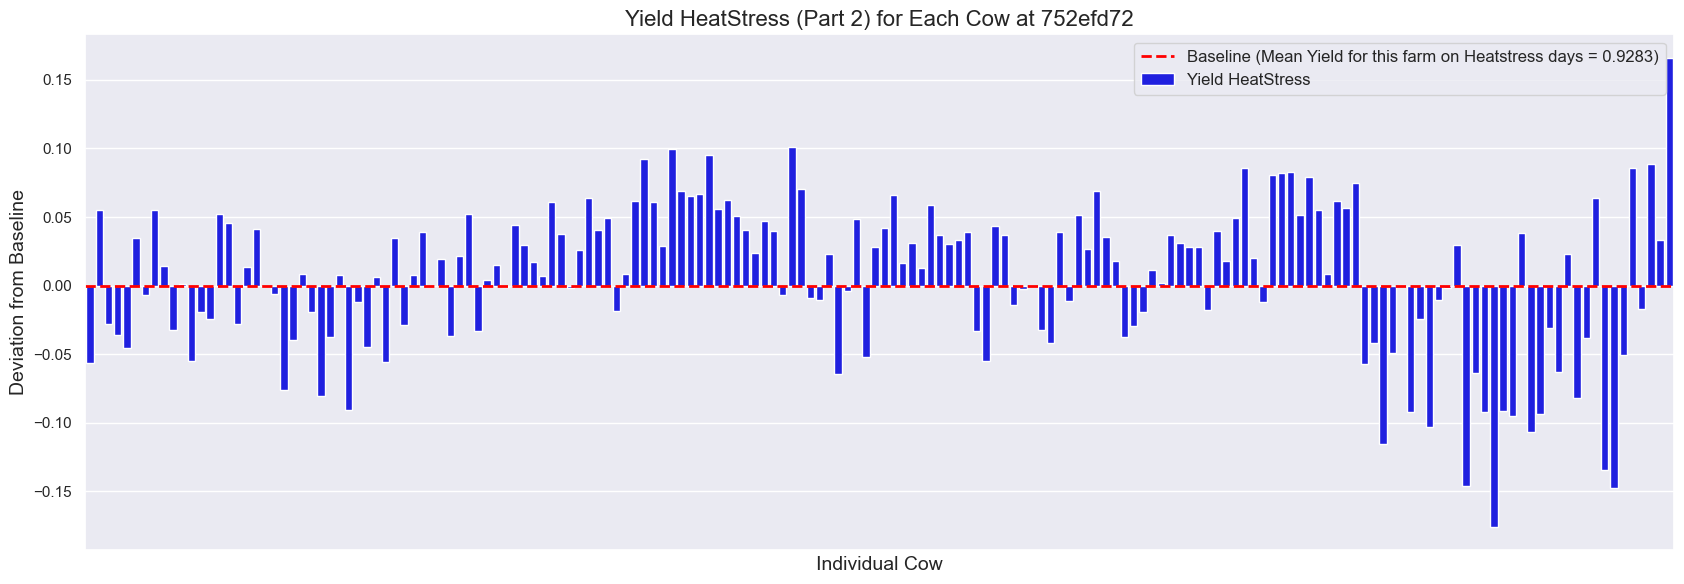

In [11]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Farm f454e660

In [12]:
# Filter data for a specific farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change
def fit_xgboost_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(test_data[[feature]])
        mse = mean_squared_error(test_data['NormalizedDailyYield'], y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)
results_df

,SE_Number,MSE,Yield HeatStress,Reduction
0,SE-a2bab923-0680,0.002820,0.863465,0.136426
1,SE-f454e660-0157,0.003044,1.061654,-0.061788
2,SE-f454e660-0250,0.003149,1.030249,-0.030379
3,SE-f454e660-0282,0.016744,0.868658,0.131233
4,SE-f454e660-0291,0.002967,0.964649,0.035229
...,...,...,...,...
57,SE-f454e660-587,0.012845,1.006250,-0.006376
58,SE-f454e660-600,0.008146,0.874607,0.125283
59,SE-f454e660-636,0.005417,1.000253,-0.000379
60,SE-f454e660-693,0.021456,0.902304,0.097582


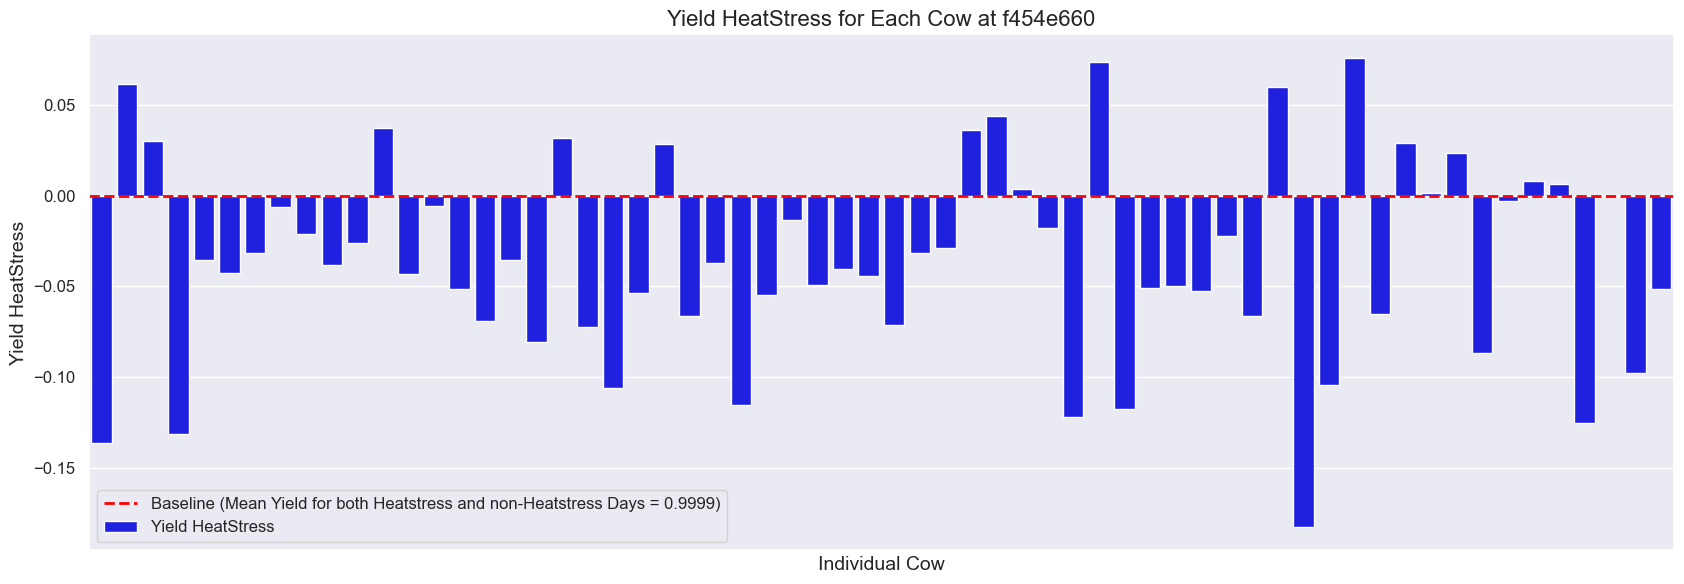

In [13]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

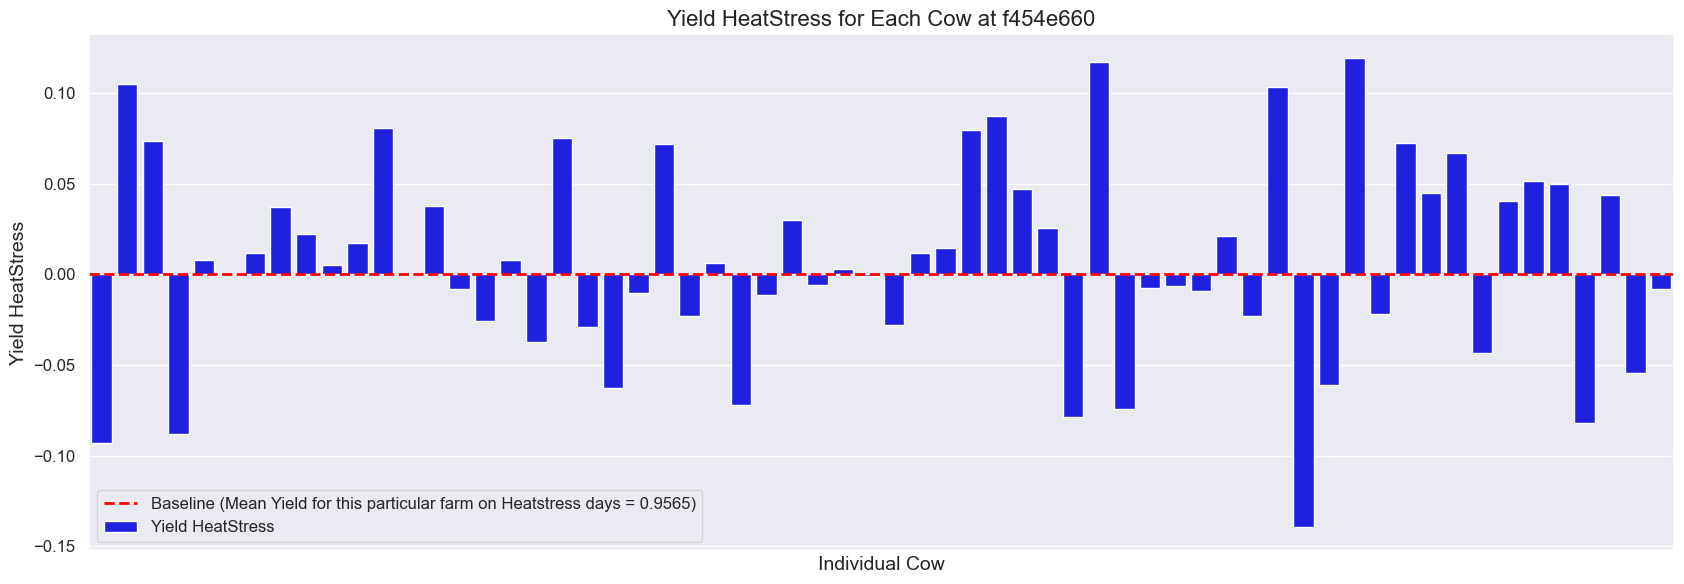

In [14]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this particular farm on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()